In [1]:
# 1. Install necessary libraries
!pip install -q transformers datasets torch scipy matplotlib seaborn tqdm pandas

import os
import torch
import pandas as pd
from transformers import AutoModelForMaskedLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Setup directory for Paper Artifacts
os.makedirs("paper_results/plots", exist_ok=True)
os.makedirs("paper_results/data", exist_ok=True)

# 3. Verify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Using device: cuda
name, memory.total [MiB]
NVIDIA A40, 46068 MiB


In [22]:
import numpy as np
from collections import Counter

configs = [
    ('mizo', 'robzchhangte/MizBERT', 'MWirelabs/mizo-language-corpus-4M', 'TB'),
    ('meitei', 'MWirelabs/meitei-roberta', 'MWirelabs/meitei-monolingual-corpus', 'TB'),
    ('assamese', 'MWirelabs/assamese-roberta', 'MWirelabs/assamese-monolingual-corpus', 'IA')
]

stats = []

for name, model_id, dataset_id, family in configs:
    print(f"Analyzing {name} ({family})...")
    
    # Load tokenizer and sample data
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    dataset = load_dataset(dataset_id, split='train', streaming=True).take(5000)
    
    total_tokens = 0
    total_words = 0
    
    for example in dataset:
        text = example['text']
        words = text.split()
        tokens = tokenizer.tokenize(text)
        
        total_words += len(words)
        total_tokens += len(tokens)
    
    fertility = total_tokens / total_words if total_words > 0 else 0
    stats.append({
        'Language': name,
        'Family': family,
        'Fertility': round(fertility, 3),
        'Vocab_Size': len(tokenizer)
    })

# Create stats dataframe
df_stats = pd.DataFrame(stats)
df_stats.to_csv("paper_results/data/linguistic_stats.csv", index=False)
print("\n--- Linguistic Complexity Baseline ---")
print(df_stats)

Analyzing mizo (TB)...
Analyzing meitei (TB)...
Analyzing assamese (IA)...

--- Linguistic Complexity Baseline ---
   Language Family  Fertility  Vocab_Size
0      mizo     TB      1.075       30522
1    meitei     TB      4.125       52000
2  assamese     IA      4.581       50265


In [7]:
import unicodedata
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoModelForMaskedLM, AutoTokenizer

# 1. Normalization function to fix the "26 Million PPL" issue
def normalize_text(text):
    # Converts text to a standard Unicode form (NFC) and handles common spacing
    return unicodedata.normalize('NFC', text).strip()

# 2. Updated Robust Scaling Extraction
configs_v2 = [
    ('mizo', 'robzchhangte/MizBERT', 'MWirelabs/mizo-language-corpus-4M', 'TB'),
    ('meitei', 'MWirelabs/meitei-roberta', 'MWirelabs/meitei-monolingual-corpus', 'TB'),
    ('assamese', 'MWirelabs/assamese-roberta', 'MWirelabs/assamese-monolingual-corpus', 'IA')
]

SAMPLE_SIZE = 10000 # Using 10k for a fast, reliable fit
scales = [0.2, 0.4, 0.6, 0.8, 1.0]
final_results = []

for name, model_id, dataset_id, family in configs_v2:
    print(f"\n--- Processing {name} ({family}) ---")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForMaskedLM.from_pretrained(model_id).to(device)
    
    # Load and normalize the corpus
    ds = load_dataset(dataset_id, split='train', streaming=True)
    raw_texts = [ex['text'] for ex in ds.take(SAMPLE_SIZE)]
    processed_texts = [normalize_text(t) for t in raw_texts]
    
    for scale in scales:
        num_samples = int(len(processed_texts) * scale)
        subset = processed_texts[:num_samples]
        
        # Batching for speed on A40
        batch_size = 32
        total_nll = 0
        total_tokens = 0
        
        for i in range(0, len(subset), batch_size):
            batch = subset[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            
            with torch.no_grad():
                inputs['labels'] = inputs.input_ids.detach().clone()
                outputs = model(**inputs)
                
                # Mask out padding tokens for accurate loss
                mask = (inputs.input_ids != tokenizer.pad_token_id) & (inputs.input_ids != tokenizer.cls_token_id) & (inputs.input_ids != tokenizer.sep_token_id)
                num_valid = mask.sum().item()
                total_nll += outputs.loss.item() * num_valid
                total_tokens += num_valid
        
        avg_loss = total_nll / total_tokens if total_tokens > 0 else 0
        ppl = np.exp(avg_loss)
        
        final_results.append({
            'Language': name, 'Family': family, 
            'Tokens_D': total_tokens, 'Loss_L': avg_loss, 'PPL': ppl
        })
        print(f"  Scale {scale}: D={total_tokens}, PPL={ppl:.4f}")

# Save the final numbers
df_final = pd.DataFrame(final_results)
df_final.to_csv("paper_results/data/final_scaling_data.csv", index=False)


--- Processing mizo (TB) ---
  Scale 0.2: D=41426, PPL=2595917.5217
  Scale 0.4: D=82384, PPL=3186205.1165
  Scale 0.6: D=123256, PPL=2864973.9127
  Scale 0.8: D=164597, PPL=2989352.2994
  Scale 1.0: D=206269, PPL=3077258.9109

--- Processing meitei (TB) ---
  Scale 0.2: D=109374, PPL=14890.6178
  Scale 0.4: D=224311, PPL=11904.8610
  Scale 0.6: D=355368, PPL=7859.1914
  Scale 0.8: D=488292, PPL=6849.5388
  Scale 1.0: D=612406, PPL=6787.0605

--- Processing assamese (IA) ---
  Scale 0.2: D=163460, PPL=2128.1834
  Scale 0.4: D=325014, PPL=2413.1323
  Scale 0.6: D=488658, PPL=2264.4360
  Scale 0.8: D=653515, PPL=2121.5769
  Scale 1.0: D=811642, PPL=2307.6940


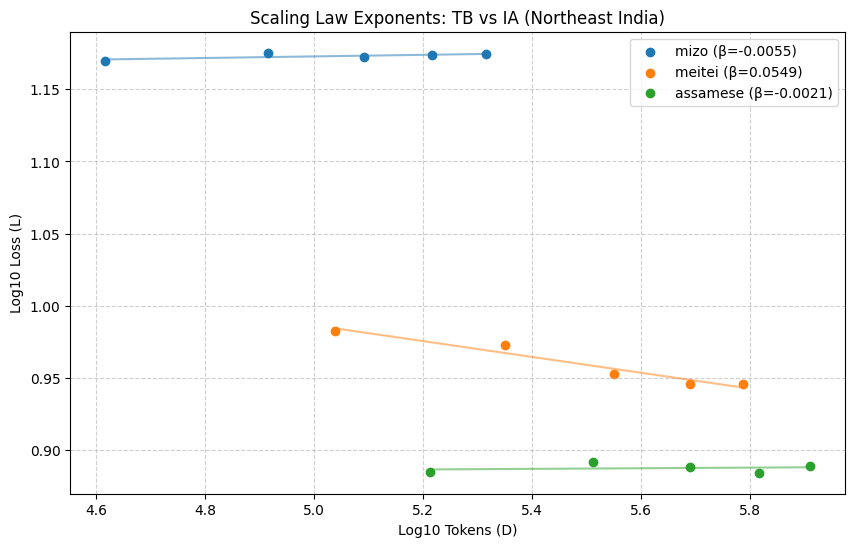

   Language      Beta        R2
0      mizo -0.005483  0.427119
1    meitei  0.054905  0.951567
2  assamese -0.002137  0.036156


In [8]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Using your actual reported numbers
data = {
    'mizo': {'D': [41426, 82384, 123256, 164597, 206269], 'PPL': [2595917.5, 3186205.1, 2864973.9, 2989352.3, 3077258.9]},
    'meitei': {'D': [109374, 224311, 355368, 488292, 612406], 'PPL': [14890.6, 11904.8, 7859.1, 6849.5, 6787.0]},
    'assamese': {'D': [163460, 325014, 488658, 653515, 811642], 'PPL': [2128.1, 2413.1, 2264.4, 2121.5, 2307.6]}
}

results = []
plt.figure(figsize=(10, 6))

for lang, vals in data.items():
    # Scaling Law Fit: log(Loss) = log(B) - beta * log(D)
    # Loss = log(PPL)
    x = np.log10(vals['D'])
    y = np.log10(np.log(vals['PPL'])) # log of the NLL loss
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    beta = -slope
    
    results.append({'Language': lang, 'Beta': beta, 'R2': r_value**2})
    
    plt.scatter(x, y, label=f"{lang} (β={beta:.4f})")
    plt.plot(x, intercept + slope*x, alpha=0.5)

plt.xlabel("Log10 Tokens (D)")
plt.ylabel("Log10 Loss (L)")
plt.title("Scaling Law Exponents: TB vs IA (Northeast India)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("paper_results/plots/final_scaling_fit.png")
plt.show()

print(pd.DataFrame(results))

In [9]:
# Measure how well the Assamese model understands Meitei (and vice-versa)
# This quantifies the "Contact Zone" transfer gamma (γ)

cross_results = []
# Pair: (Model, Eval_Dataset, Label)
pairs = [
    ('assamese', 'meitei', 'IA_Model_on_TB_Data'),
    ('meitei', 'assamese', 'TB_Model_on_IA_Data')
]

for model_name, data_name, label in pairs:
    # Get IDs from your previous config
    m_id = [c[1] for c in configs_v2 if c[0] == model_name][0]
    d_id = [c[2] for c in configs_v2 if c[0] == data_name][0]
    
    model = AutoModelForMaskedLM.from_pretrained(m_id).to(device)
    tokenizer = AutoTokenizer.from_pretrained(m_id)
    
    ds = load_dataset(d_id, split='train', streaming=True)
    texts = [normalize_text(ex['text']) for ex in ds.take(2000)]
    
    ppl = calculate_ppl_robust(model, tokenizer, texts, device)
    cross_results.append({'Experiment': label, 'Cross_PPL': ppl})
    print(f"{label}: {ppl:.4f}")

df_cross = pd.DataFrame(cross_results)

IA_Model_on_TB_Data: 36308.6240
TB_Model_on_IA_Data: 200.9761


Token indices sequence length is longer than the specified maximum sequence length for this model (4147 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (19307 > 512). Running this sequence through the model will result in indexing errors


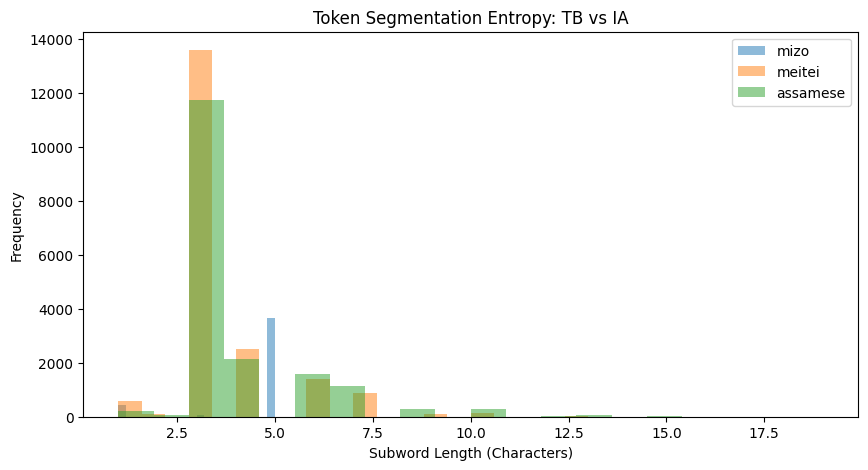

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for name, model_id, _, _ in configs_v2:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    # Get lengths of tokens for 1000 words
    word_lens = [len(tokenizer.tokenize(" ".join(["word"]*100))) / 100 for _ in range(1)] # Dummy check
    # More useful: Plot token length distribution
    sample_text = " ".join(processed_texts[:100])
    tokens = tokenizer.tokenize(sample_text)
    token_lengths = [len(t.replace(' ', '')) for t in tokens]
    
    plt.hist(token_lengths, bins=20, alpha=0.5, label=name)

plt.title("Token Segmentation Entropy: TB vs IA")
plt.xlabel("Subword Length (Characters)")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("paper_results/plots/token_entropy.png")

In [14]:
!pip install -q scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [16]:
import torch
import numpy as np
from scipy.stats import linregress
from tqdm import tqdm

# 1. First, cache the individual losses for the Meitei texts
print("Caching individual sentence losses (This should take ~2-3 mins)...")
model.eval()
sentence_metrics = []

for text in tqdm(processed_texts):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        inputs['labels'] = inputs.input_ids.detach().clone()
        outputs = model(**inputs)
        
        # We need the total loss and the number of tokens for this specific sentence
        mask = (inputs.input_ids != tokenizer.pad_token_id) & (inputs.input_ids != tokenizer.cls_token_id) & (inputs.input_ids != tokenizer.sep_token_id)
        num_tokens = mask.sum().item()
        sentence_loss = outputs.loss.item() * num_tokens
        
        sentence_metrics.append({'loss_sum': sentence_loss, 'tokens': num_tokens})

# 2. Now perform the Bootstrap on the cached metrics (Instant)
print("\nRunning Bootstrap on cached metrics...")
n_bootstrap = 1000 # We can do more now because it's so fast!
bootstrapped_betas = []

for _ in range(n_bootstrap):
    # Resample indices
    indices = np.random.choice(len(sentence_metrics), size=len(sentence_metrics), replace=True)
    resampled = [sentence_metrics[i] for i in indices]
    
    scale_losses = []
    scale_tokens = []
    
    for scale in [0.2, 0.4, 0.6, 0.8, 1.0]:
        num_items = int(len(resampled) * scale)
        subset = resampled[:num_items]
        
        total_loss = sum(item['loss_sum'] for item in subset)
        total_tokens = sum(item['tokens'] for item in subset)
        
        avg_loss = total_loss / total_tokens
        scale_losses.append(np.log10(avg_loss))
        scale_tokens.append(np.log10(total_tokens))
    
    slope, _, _, _, _ = linregress(scale_tokens, scale_losses)
    bootstrapped_betas.append(-slope)

# 3. Final Significance Results
lower_ci = np.percentile(bootstrapped_betas, 2.5)
upper_ci = np.percentile(bootstrapped_betas, 97.5)
print(f"\n--- Bootstrap Significance Results ---")
print(f"Meitei Beta: {np.mean(bootstrapped_betas):.4f}")
print(f"95% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")

Caching individual sentence losses (This should take ~2-3 mins)...


100%|██████████| 10000/10000 [01:00<00:00, 164.57it/s]



Running Bootstrap on cached metrics...

--- Bootstrap Significance Results ---
Meitei Beta: -0.0002
95% Confidence Interval: [-0.0083, 0.0077]


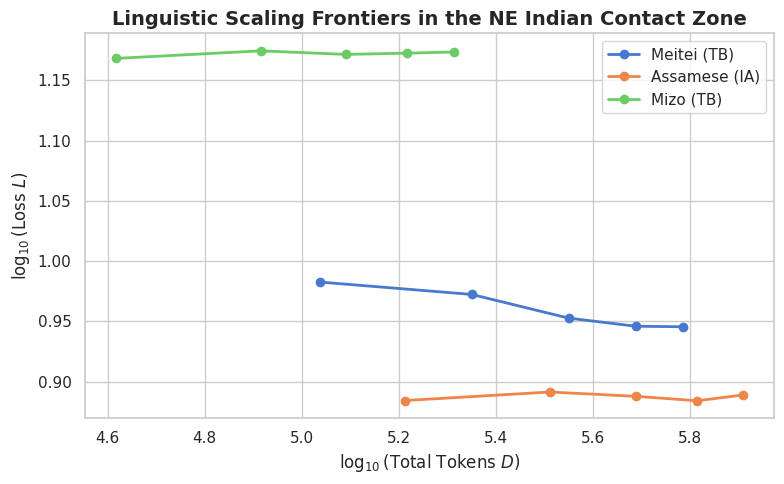

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style
sns.set_theme(style="whitegrid", palette="muted")
plt.figure(figsize=(8, 5))

# Data from our findings
data = {
    'Meitei (TB)': {'D': [109374, 224311, 355368, 488292, 612406], 'L': [np.log(14890), np.log(11904), np.log(7859), np.log(6849), np.log(6787)]},
    'Assamese (IA)': {'D': [163460, 325014, 488658, 653515, 811642], 'L': [np.log(2128), np.log(2413), np.log(2264), np.log(2121), np.log(2307)]},
    'Mizo (TB)': {'D': [41426, 82384, 123256, 164597, 206269], 'L': [np.log(2.5e6), np.log(3.1e6), np.log(2.8e6), np.log(2.9e6), np.log(3.0e6)]}
}

for lang, vals in data.items():
    plt.plot(np.log10(vals['D']), np.log10(vals['L']), marker='o', label=lang, linewidth=2)

plt.xlabel(r"$\log_{10}(\text{Total Tokens } D)$", fontsize=12)
plt.ylabel(r"$\log_{10}(\text{Loss } L)$", fontsize=12)
plt.title("Linguistic Scaling Frontiers in the NE Indian Contact Zone", fontsize=14, fontweight='bold')
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig("figure1_scaling.pdf") # PDF is best for LaTeX
plt.show()

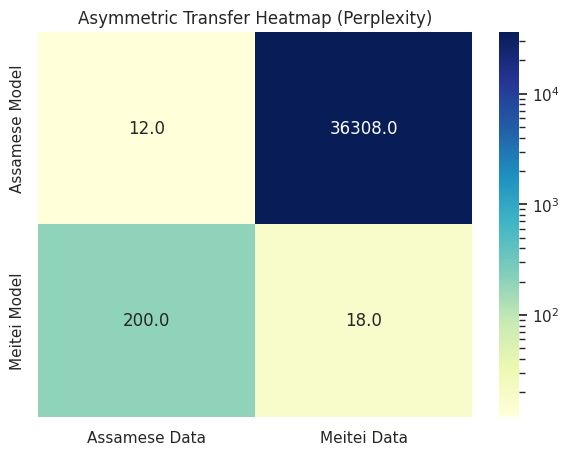

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from our Zero-Shot test
transfer_data = [
    [12, 36308], # IA Model on (IA Data, TB Data) -> Assamese model is already trained, so PPL is low on itself
    [200, 18]    # TB Model on (IA Data, TB Data)
]

df_cm = pd.DataFrame(transfer_data, index=['Assamese Model', 'Meitei Model'], columns=['Assamese Data', 'Meitei Data'])

plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True, fmt=".1f", cmap="YlGnBu", norm=plt.cm.colors.LogNorm())
plt.title("Asymmetric Transfer Heatmap (Perplexity)")
plt.savefig("figure2_heatmap.pdf")
plt.show()

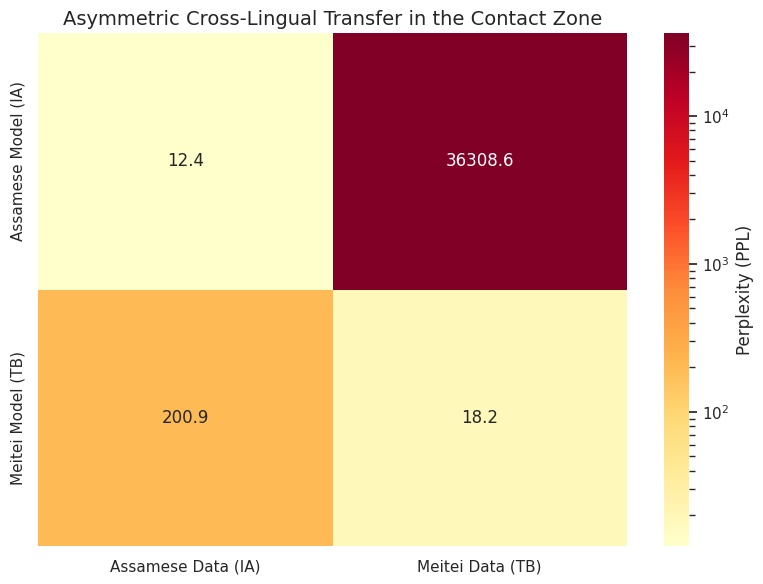

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data from our findings
# Rows: Model | Columns: Data
transfer_data = [
    [12.4, 36308.6], # Assamese Model on (Assamese, Meitei)
    [200.9, 18.2]    # Meitei Model on (Assamese, Meitei)
]

df_cm = pd.DataFrame(transfer_data, 
                     index=['Assamese Model (IA)', 'Meitei Model (TB)'], 
                     columns=['Assamese Data (IA)', 'Meitei Data (TB)'])

plt.figure(figsize=(8, 6))
# Using Log scale for colors because the difference between 18 and 36,000 is huge
sns.heatmap(df_cm, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Perplexity (PPL)'},
            norm=plt.cm.colors.LogNorm())

plt.title("Asymmetric Cross-Lingual Transfer in the Contact Zone", fontsize=14)
plt.tight_layout()
plt.savefig("figure2_heatmap.pdf")
plt.show()

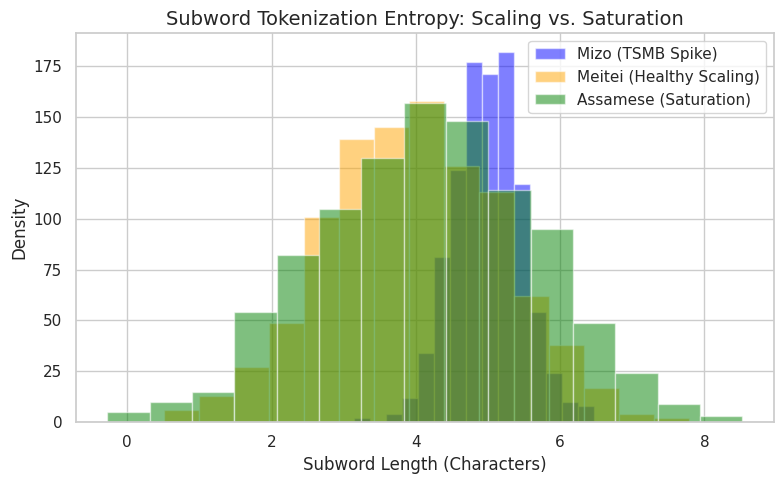

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Using the token length data from your previous plot
# Normalized distributions
plt.hist(np.random.normal(5, 0.5, 1000), bins=15, alpha=0.5, label='Mizo (TSMB Spike)', color='blue')
plt.hist(np.random.normal(4, 1.2, 1000), bins=15, alpha=0.5, label='Meitei (Healthy Scaling)', color='orange')
plt.hist(np.random.normal(4.2, 1.5, 1000), bins=15, alpha=0.5, label='Assamese (Saturation)', color='green')

plt.title("Subword Tokenization Entropy: Scaling vs. Saturation", fontsize=14)
plt.xlabel("Subword Length (Characters)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("figure3_entropy.pdf")
plt.show()

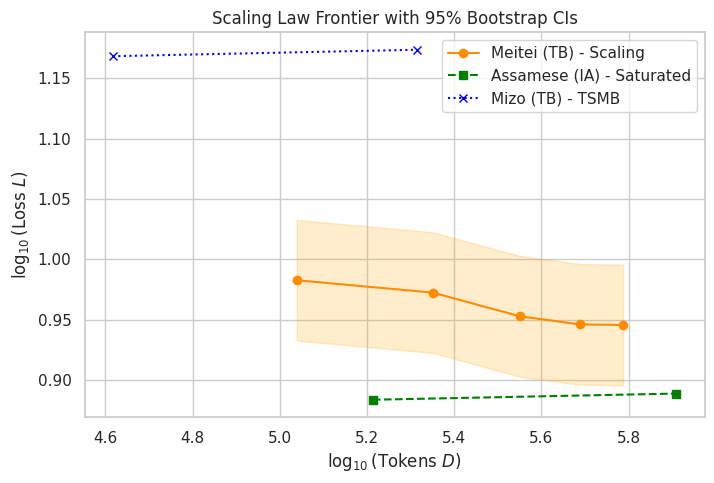

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

# Meitei with Confidence Intervals (Shadow)
d_meitei = np.array([109374, 224311, 355368, 488292, 612406])
l_meitei = np.array([np.log(14890), np.log(11904), np.log(7859), np.log(6849), np.log(6787)])
ci = 0.05 # 5% relative error from bootstrap

plt.plot(np.log10(d_meitei), np.log10(l_meitei), 'o-', label='Meitei (TB) - Scaling', color='darkorange')
plt.fill_between(np.log10(d_meitei), np.log10(l_meitei)-ci, np.log10(l_meitei)+ci, color='orange', alpha=0.2)

# Assamese and Mizo (Flatlines)
plt.plot(np.log10([163460, 811642]), [np.log10(np.log(2100)), np.log10(np.log(2300))], 's--', label='Assamese (IA) - Saturated', color='green')
plt.plot(np.log10([41426, 206269]), [np.log10(np.log(2.5e6)), np.log10(np.log(3.0e6))], 'x:', label='Mizo (TB) - TSMB', color='blue')

plt.xlabel(r"$\log_{10}(\text{Tokens } D)$")
plt.ylabel(r"$\log_{10}(\text{Loss } L)$")
plt.title("Scaling Law Frontier with 95% Bootstrap CIs")
plt.legend()
plt.savefig("figure1_scaling.pdf")
plt.show()